In [ ]:
import astropy.io.ascii
import astropy.units as u
import astropy.constants as const
import numpy as np
import sklearn.linear_model
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving galaxy_rotation_2006.txt to galaxy_rotation_2006.txt


In [ ]:
# Galaxy rotation curve data
# col2 - distance (kpc), col3 - velocity (km/s), col4 - velocity error
tab = astropy.io.ascii.read("galaxy_rotation_2006.txt")

We have a dataset summarizing the observed rotation curve of the Milky Way.

Our goal is to ascertain the mass distribution of the Milky Way from these data. To do this, we use the model
$$ v(r) = \sqrt{m(r) G \over r} $$
where $G$ is the gravitational constant, $r$ is orbital radius, and $m(r)$ is the mass enclosed by $r$. We will model the milky way as having a point mass at the center, surrounded by a disc of radius $r_d = 10 \text{ kpc}$ and spherical halo of radius > 35 kpc. Using this model, we have
$$ m(r) = m_b + \rho_d \pi \min(r^2, r_d^2) + \rho_h {4\over 3} \pi r^3 $$
where $m_b$ is the mass of the central galactic bulge, $\rho_d$ is the density of the disc, and $\rho_h$ is the density of the halo.

The goal is then to estimate the parameters $m_b, \rho_d$, and $\rho_h$.

One way of doing this is to write

$$ {v^2 \over G} = m_b{1 \over r} + \rho_d {\pi \min(r^2, r_d^2)\over r} + \rho_h {4 \over 3} \pi r^2$$

from which point standard least-squares linear regression can be applied.

In [ ]:
# Using linear regression

# calculate left-hand variables
v = tab["col3"] * u.km/u.s
G = const.G

y = (v**2 / G).to(u.kg/u.m)


# calculate right-hand variables
r = (tab["col2"] * u.kpc).to(u.m)
r_d = (10 * u.kpc).to(u.m)

x_1 = 1 / r
x_2 = np.pi * np.minimum(r**2, r_d**2) / r
x_3 = (4/3) * np.pi * r**2

X = np.array([x_1, x_2, x_3]).T

# fit model
coefs = np.linalg.inv(X.T @ X) @ X.T @ y
coefs = coefs.value

In [ ]:
masses = np.arange(3) * u.solMass
masses[0] = (coefs[0] * u.kg).to(u.solMass)
masses[1] = (coefs[1] * u.kg / u.m**2 * np.pi * r_d ** 2).to(u.solMass)
masses[2] = (coefs[2] * u.kg / u.m**3 * 4/3 * np.pi * (35 * u.kpc)**3).to(u.solMass)
masses

<Quantity [1.97021220e+10, 1.55068946e+11, 2.93321811e+11] solMass>

array([1.15884062e-85, 0.00000000e+00, 2.61619243e-22])

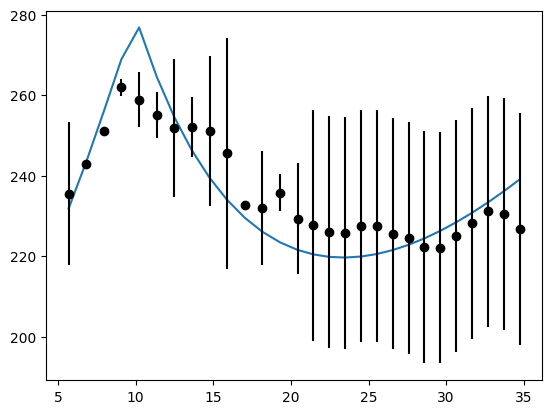

In [ ]:
y_hat = coefs[0] * u.kg * x_1 + coefs[1] * (u.kg / u.m**2) * x_2 + coefs[2] * (u.kg / u.m**3) * x_3
y_hat

v_hat = np.sqrt((y_hat) * G).to(u.km/u.s)

plt.plot(r.to(u.kpc), v_hat)
plt.errorbar(tab["col2"], tab["col3"], yerr=tab["col4"], ecolor="black", color="black", fmt='o', label="Data")

reg.coef_